# Exploratory Data Analysis (EDA)
We'll start our journey with analyzing the subject dataset to understand it and get insights in order to prepare the data for training a machine learning solution.

__Important Note:__<br>
EDA (and almost all data preprocessing steps) should be done on __train data only__. This is a crucial principle that gets ignored in many online hands-on articles and some real project workflows. Inobservance of this fact could lead to serious __*Data Leakage*__ and degrade model performance on unseen data.<br>

<p align="center">
    <img src="./assets/tweet_eda.png" width="500" />
</p>
<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Nice work but there&#39;s a critical flaw here. Most of the data preparation steps like transforms, feature selection, dimensionality reduction, feature engineering and even EDA must be done AFTER data split, on Train data only. Doing those steps before leads to serious data leakage.</p>&mdash; Hamed (@hamedonline) <a href="https://twitter.com/hamedonline/status/1444202825345601536?ref_src=twsrc%5Etfw">October 2, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>
<br>

Since we're provided with both Train & Test data in this study from the beginning, it is safe to do the EDA on train data. If this was not the case and there was only one data source, we had to apply a train/test split manually and never touch the test split for any insights or data preprocessing decisions.

The proper way to do a such manual split would be doing a split that takes into consideration the distribution of samples in both splits based on the _'target column'_. __*Stratified KFold*__ in __*sklearn*__ package allows us to apply this easily and get a random split with equal target distribution in mind:

```python
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True)
# make sure target distribution remains the same by utilizing StratifiedKFold data split
train_indices, test_indices = next(skf.split(X=dataframe, y=dataframe['target column name']), 0)
```

In [1]:
# required library imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import adjusted_mutual_info_score

## Reading Raw Data

In [2]:
# define relative data path (according the current path of this notebook)
DATA_PATH = './scripts/data/'

df_train_full = pd.read_csv(DATA_PATH+'train.csv.gz')
df_test = pd.read_csv(DATA_PATH+'test.csv.gz')

df_train_full.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


As the column names suggest, we won't have __*"Domain Knowledge"*__ about the dataset since neither column names & categorical values nor dataset provider's description indicate what each column is about. Because of that, any _"Feature Engineering"_ attempts would be like _try & check the impact_ and an extensive amount of possibilities is imaginable.

Since we don't have domain knowledge about columns, we make an assumption and consider all columns useful for now (we could very well be wrong).

## Initial Data Insights

In [3]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [4]:
# descriptive statistical summary for numerical columns

pd.set_option('display.max_columns', None)

df_train_full.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [5]:
# descriptive statistical summary for categorical columns

df_train_full.describe(include="object")

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116
count,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318,188318
unique,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,8,7,8,7,5,7,5,8,7,5,16,15,19,9,13,17,20,17,20,11,84,131,16,51,61,19,23,326
top,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,D,D,B,B,C,B,B,B,A,A,A,A,A,D,D,C,E,C,A,P,F,A,A,A,E,E,G,F,B,BI,CL,A,E,BM,A,K,HK
freq,141550,106721,177993,128395,123737,131693,183744,177274,113122,160213,168186,159825,168851,186041,188284,181843,187009,187331,186510,188114,187905,188275,157445,181977,169969,177119,168250,180938,184593,184760,182980,187107,187361,187734,188105,156313,165729,169323,183393,180119,181177,186623,184110,172716,183991,187436,187617,188049,179127,137611,187071,179505,172949,183762,188173,188136,185296,188079,188018,187872,187596,188273,188239,188271,186056,179982,187626,188176,188011,188295,178646,118322,154275,184731,154307,181347,187503,186526,152929,137505,154385,147536,141534,154939,186005,103852,166992,168926,183744,177993,111028,124689,150237,121642,87531,174360,78127,105492,79455,42970,106721,177274,123737,42925,76493,47165,47310,65512,152918,25305,128395,25148,26191,131693,43866,21061


The stats in above lines indicate that our subject dataset contains __188318__ samples (which is a good indicator; the more data, the better) and __132__ columns including 116 of categorical & 16 of numerical data type.

All the feature column names indicate data type (cat, cont) and are numbered (cat1, cat2, ...) in ordered fashion. Classes in categorical features are obfuscated by being titled as _A_, _B_, _C_, etc.

Many of the categorical columns (62% to be exact) contain only two unique values (several might be of boolean nature). There are also a few of categorical columns with value variety above 50!<br>
There is only one discrete numerical column (namely _'id'_ which corresponds to sample id) and the remaining 15 numerical columns are all continuos.

## Identifying Data Column Types
- Column type identification is an essential step in data understanding phases:
  - We need to understand & differentiate column types in order to perform numerical & categorical data transforms later.
  - Another reason for the isolation is that we will be applying different visualization techniques on them.
  - Getting to categorize column types lets us spot the mis-identified ones easier via visualization, thus helping us in converting them back to a proper format.
- Column type identification can be done either __"Manually"__ or __"Automatically"__.
- We don't get the chance of having domain knowledge or reasonable count of columns all the time to enable us explore them all (just like the subject dataset in this study).
- Although you may automatically differentiate column types, some columns of the other type could still be found among differentiated list due to careless or inconsiderate data preparation. Therefore, you must review separated types to make sure that no such cases exist.

In [6]:
# automatic column type identification
columns_numerical = df_train_full.select_dtypes(include=['number']).columns.to_list()
columns_numerical_discrete   = df_train_full.select_dtypes(include=['integer']).columns.to_list()
columns_numerical_continuous = df_train_full.select_dtypes(include=['inexact']).columns.to_list()

columns_categorical = df_train_full.select_dtypes(include=['flexible', 'object', 'bool']).columns.to_list()
columns_datetime    = df_train_full.select_dtypes(include=['datetime64', 'timedelta64']).columns.to_list()

print(f'Numerical Columns (Discrete):\n{columns_numerical_discrete}', '\n')
print(f'Numerical Columns (Continuous):\n{columns_numerical_continuous}', '\n')
print(f'Categorical Columns:\n{columns_categorical}', '\n')
print(f'Datetime Columns:\n{columns_datetime}', '\n')

Numerical Columns (Discrete):
['id'] 

Numerical Columns (Continuous):
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'loss'] 

Categorical Columns:
['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 

In [7]:
# manual features grouping

features_numerical   = [column for column in df_train_full if column.startswith('cont')]
features_categorical = [column for column in df_train_full if column.startswith('cat')]
column_target = 'loss'

print(f'Target Column:\n{column_target}', '\n')
print(f'Numerical Features: {len(features_numerical)}\n{features_numerical}', '\n')
print(f'Categorical Features: {len(features_categorical)}\n{features_categorical}', '\n')

Target Column:
loss 

Numerical Features: 14
['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14'] 

Categorical Features: 116
['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'c

## Feature Analysis

### Numerical Features
We start with numerical features to get a better view on feature columns. For numerical data, we're interested in finding out following characteristics:
- **"Distribution"** of values and whether or not they follow **Normal/Gaussian** distribution or **skewness** is present. How? => By using distribution plot (**histogram**).
- **"Statistical Characteristics"** of columns (like mean, median, mode, etc.) => By using **Boxplots**.


**Note:** We normally like our numerical data columns to follow normal/gaussian distribution in machine learning. EDA insights regarding the distribution of values helps us to identify the columns that need to be **normalized**. On the other hand, statistical characteristics help us to identify samples with **outlier** values that we might need to filter out later on during the data cleaning step.

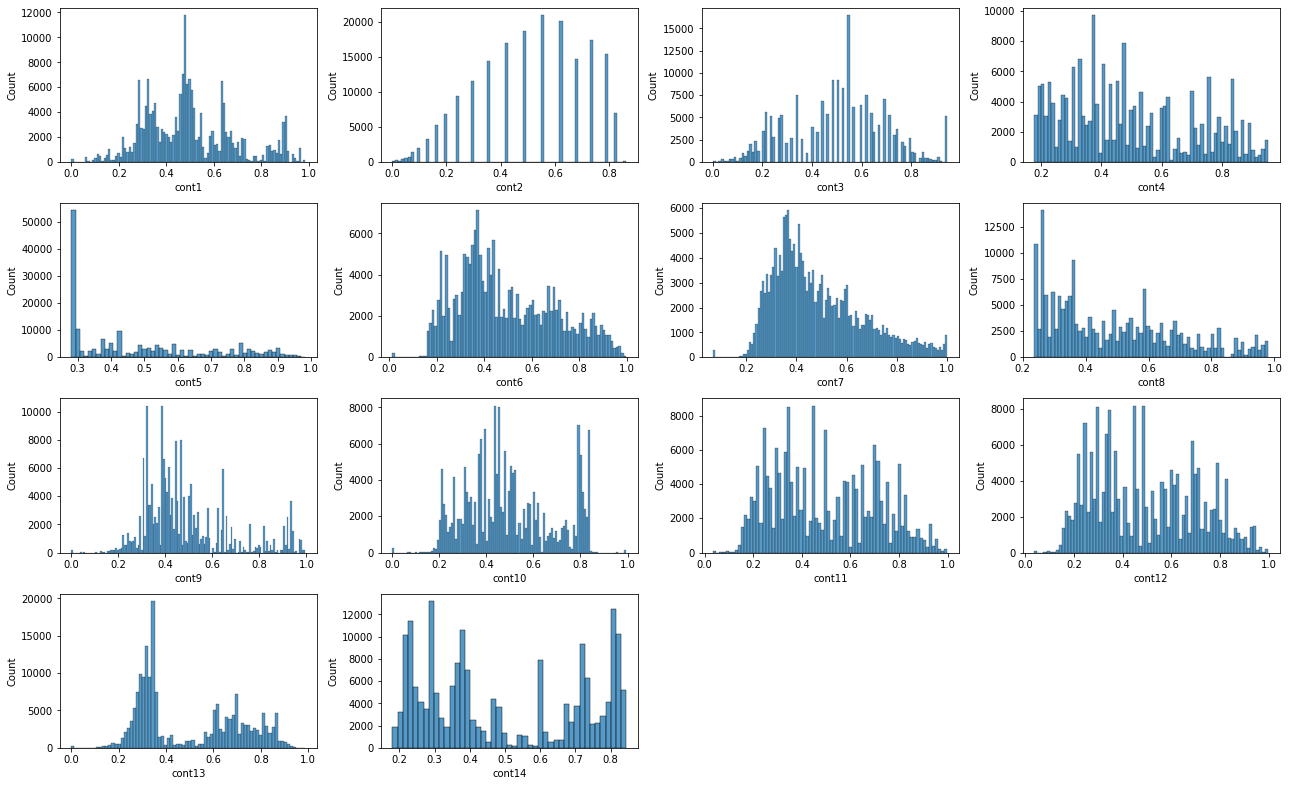

In [8]:
# distribution plot of continuous features

fig = plt.figure(figsize=(18, 16))

for index, column in enumerate(df_train_full[features_numerical]):
    plt.subplot(6, 4, index+1)
    sns.histplot(df_train_full[column].dropna(), kde=False)

fig.tight_layout(pad=1.0)

As we can see from above plots, some numerical features exhibit pretty close behavior to normal distribution (for example, _'cont1'_ and _'cont3'_), some other are very skewed (_'cont5'_ and _'cont8'_), and some partially so (_'cont6'_, _'cont7'_). We'll consider these observations for normalizing the features.

Gaussian-like: _['cont1', 'cont2', 'cont3', 'cont6', 'cont7', 'cont9', 'cont11', 'cont12']_<br>
Non-Gaussian-like: _['cont4', 'cont5', 'cont8', 'cont10', 'cont13', 'cont14']_

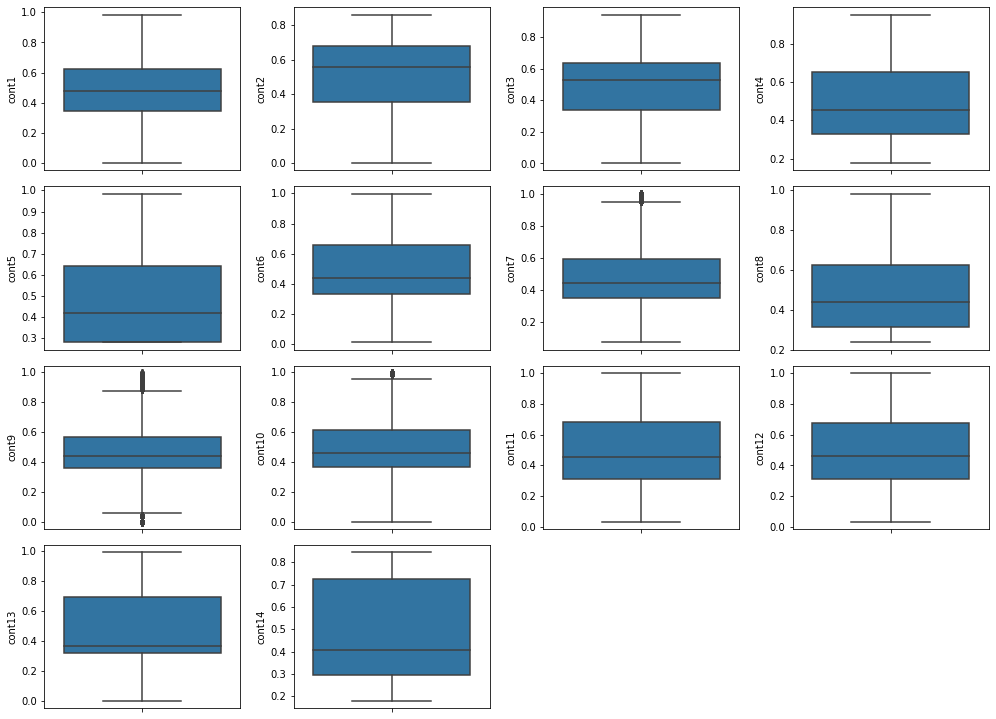

In [9]:
# boxplots of continuous features

fig = plt.figure(figsize=(14, 15))

for index, column in enumerate(df_train_full[features_numerical]):
    plt.subplot(6, 4, index+1)
    sns.boxplot(y=column, data=df_train_full.dropna())

fig.tight_layout(pad=1.0)

Some apparent outlier values are present in _'cont7'_, _'cont9'_ and _'cont10'_ columns.

### Categorical Features
In the case of categorical features, we will often use "countplots" to visualize the count of each distinct value within each feature column.<br>
What to look out for in this part:
- Sparse classes of categories which have the potential to affect a model's performance.
- Categorical columns with a large ratio of values belonging to just one class.
- Mistakes in labeling of the classes, for example two exact classes with minor spelling differences.

We already know from initial data insights that there are 116 categorical features in our subject dataset. Therefore bear in mind that running the following lines might take quite some time to render the plots.

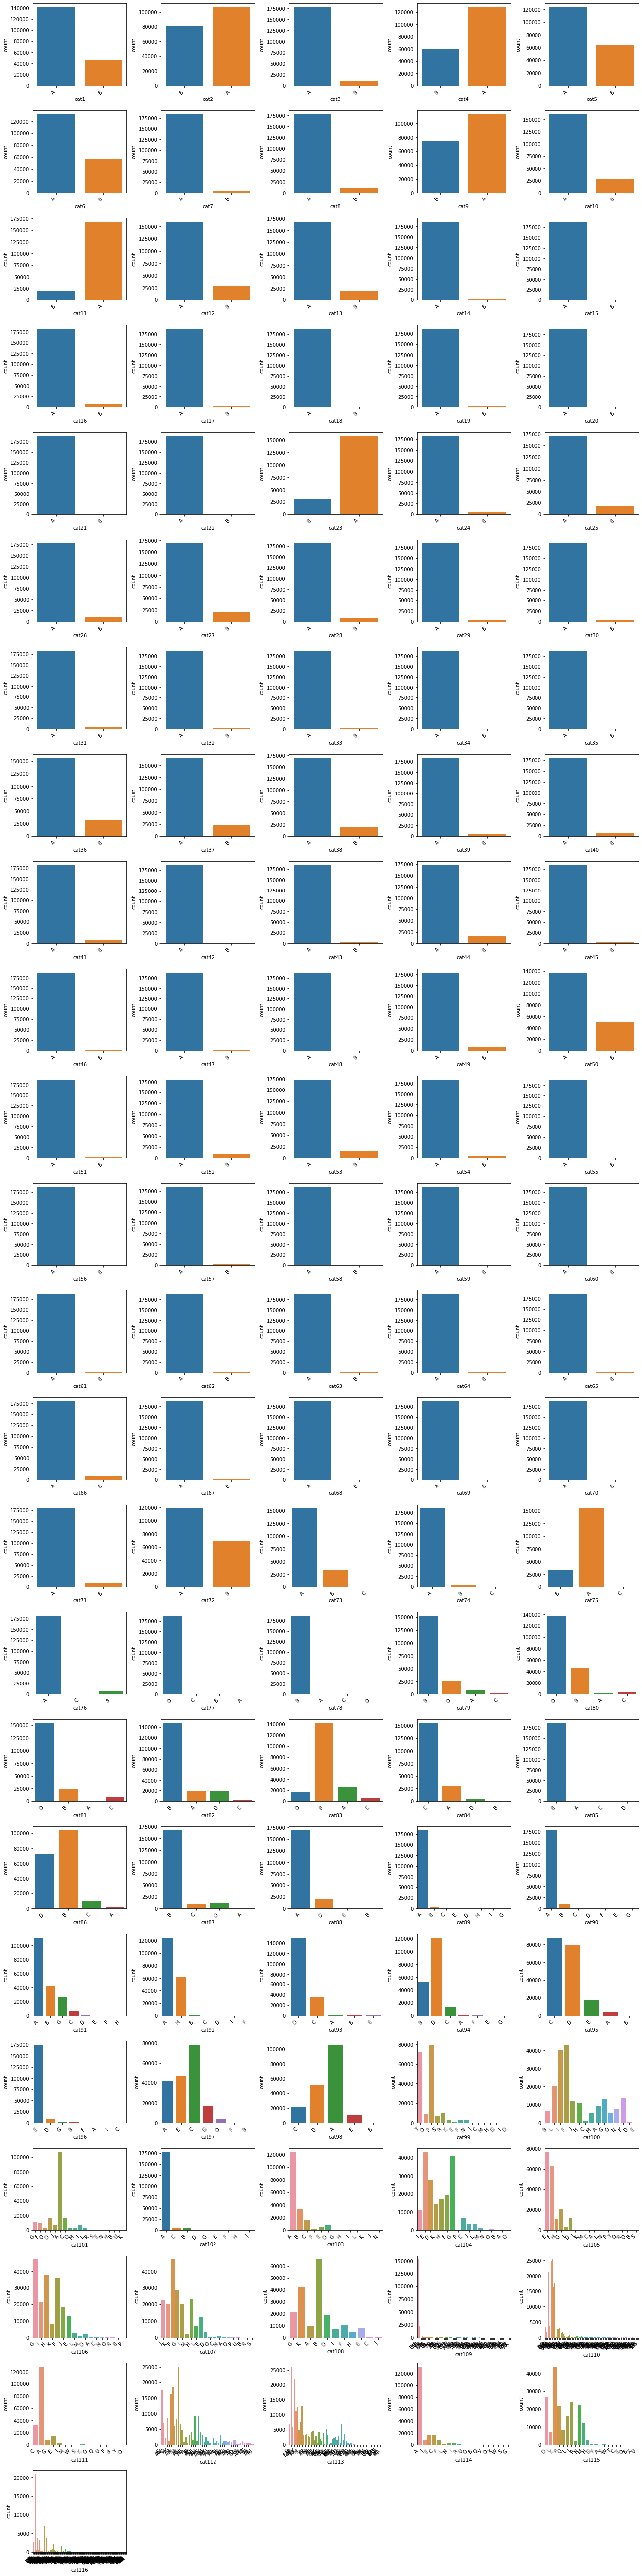

In [10]:
# value distribution plot for categorical features

features_categorical_count = len(df_train_full[features_categorical].columns)
plots_per_row  = 5
number_of_rows = (features_categorical_count // plots_per_row) + 1

fig = plt.figure(figsize=(18, number_of_rows*3))
for index in range(features_categorical_count):
    plt.subplot(number_of_rows, plots_per_row, index+1)
    sns.countplot(x=df_train_full[features_categorical].iloc[:,index], data=df_train_full[features_categorical])
    plt.xticks(rotation=45, ha='right')

fig.tight_layout(pad=1.0)

What insights do we get from above plot?
- There are substantial number of features that majority of their values belong to only one class of category. These are the columns that _might_ not be useful and dropping them _might_ increase the model performance. Examples? _'cat15'_, _'cat22'_, ...
- Some categorical columns contain very sparse classes of values (_'cat109'_, _'cat110'_, _'cat112'_, ...). Although dropping them may hurt the model performance, but we should also be careful about one-hot encoding them; because too many features could result in enormous feature space and lead to ["Curse of Dimensionality"](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

In [11]:
# finding categorical features with 99.9% of samples belonging to only one sub-class

highly_skewed_threshold = 0.999

highly_skewed_categorical = []

print('Very Highly Skewed Categorical Columns:\n')
print('Column Name \t Frequent Value Ratio'.expandtabs(20))
for column_name in df_train_full[features_categorical].columns:
    value_counts = df_train_full[column_name].value_counts()
    most_frequent_value_count = value_counts.iloc[0]
    frequency = most_frequent_value_count / len(df_train_full)
    if frequency >= highly_skewed_threshold:
        highly_skewed_categorical.append(column_name)
        print('{}: \t {:.2%}'.format(column_name, frequency).expandtabs(20))

print(f'\nFeature Names:\n{highly_skewed_categorical}')

Very Highly Skewed Categorical Columns:

Column Name          Frequent Value Ratio
cat15:               99.98%
cat22:               99.98%
cat55:               99.92%
cat56:               99.90%
cat62:               99.98%
cat63:               99.96%
cat64:               99.98%
cat68:               99.92%
cat70:               99.99%

Feature Names:
['cat15', 'cat22', 'cat55', 'cat56', 'cat62', 'cat63', 'cat64', 'cat68', 'cat70']


Now let's find out if there are any categorical columns in test dataset which contain feature classes not present in train data:

In [12]:
# finding categorical column(s) in test dataset which contain feature classes not present in train data

categorical_test_columns_with_classes_missing_in_train = [column for column in features_categorical if len(set(df_test[column].value_counts().index) - set(df_train_full[column].value_counts().index)) > 0]

print(f'Columns in categorical test features with classes not present in train data: {len(categorical_test_columns_with_classes_missing_in_train)}\n{categorical_test_columns_with_classes_missing_in_train}')

Columns in categorical test features with classes not present in train data: 11
['cat89', 'cat92', 'cat96', 'cat99', 'cat103', 'cat106', 'cat109', 'cat110', 'cat111', 'cat113', 'cat116']


Yes, such feature columns exist and it's good to know this beforehand.

### Bi-variate Analysis
To further deepen our insights and uncover potential patterns in the data, we will also need to find out more about the relationship all these features have with one another. Bi-variate analysis looks at __two different features__ to identify any possible relationship or distinctive patterns between the two.

__Why is it important to conduct bi-variate analysis?__<br>
Bi-variate analysis enables us to investigate any **multicollinearity** between our independent predictors (features).<br>
Multicollinearity happens when two or more independent variables are highly correlated with one another. In such situations, it causes precision loss in our regression coefficients, affecting our ability to identify the most important features that are most useful to our model. Therefore, keeping only one of two collinear features and dropping the other one can help our model (this is subjective though; we must check the impact thoroughly).

One of the commonly used techniques for bi-variate analysis is __"Correlation Matrix"__. Correlation matrix is an effective tool to uncover __linear relationship (correlation) between any two continuous features__.<br>
On the other hand, __mutual information__ is a promising option for bi-variate analysis between __categorical features__.

#### Correlation Matrix
We'll start with correlation analysis on numerical features of our dataset.

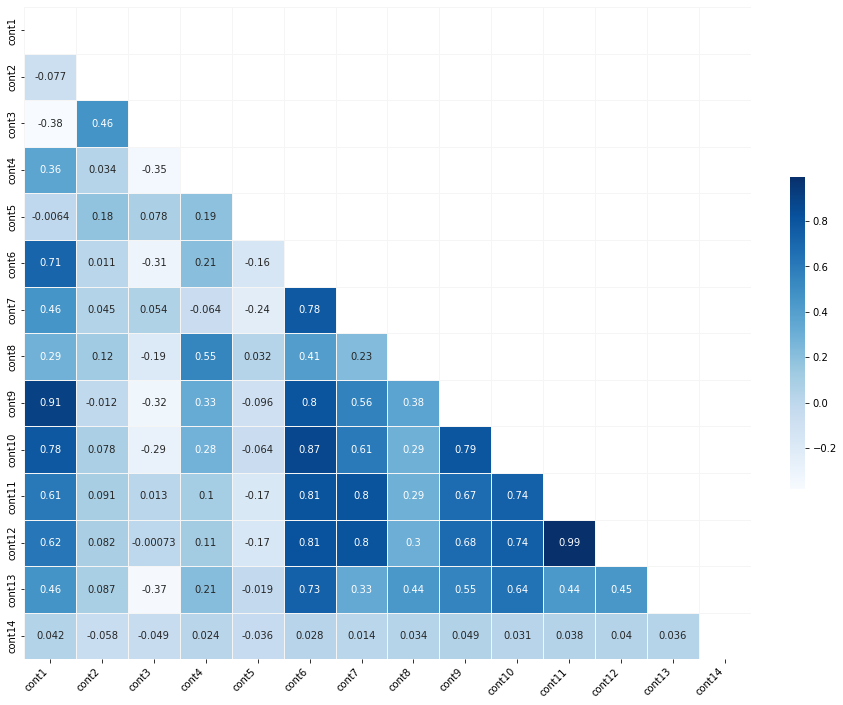

In [13]:
# plot correlation matrix

correlation = df_train_full[features_numerical].corr(method='spearman')

# create a mask to keep only half of matrix
trimask_numerical = np.triu(np.ones_like(correlation, dtype=bool))

plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, linewidth=1, linecolor='whitesmoke', cmap='Blues', mask=trimask_numerical, annot=True, cbar_kws={'fraction' : 0.02})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

None # don't show the label objects

We observe that _'cont11'_ and _'cont12'_ features are very highly correlated, and it could be helpful to get rid of one.

#### Mutual Information
Just like what we had the as correlation matrix for numerical features, we can compose a mutual information score matrix for categorical features.

- One thing to note is that, for each categorical column, we need to calculate the mutual information score it bears with with the other categorical columns; the score value shows __relative importance__ and in order to be able to interpret it, I've scaled the values for each categorical feature relatively.
- Another important factor is that mutual information calculation function is not a fast one and we've got to call it for each categorical feature versus all other categorical ones => Time complexity: O(n^2). Since our dataset is a large one, both in terms of categorical features count (116) and sample rows (188318), I decided to limit number of samples (rows), which I believe should be fine to provide us with a decent __estimation__.
- __Warning__: running the following cell still takes quite some time to complete.

With those in mind, let's get to business:

In [14]:
RANDOM_SEED = 1024
subsample_fraction = 0.06
max_samples = int(subsample_fraction * len(df_train_full))
df_train_subsample = df_train_full.sample(n=max_samples, random_state=RANDOM_SEED)


# function to scale a list of numbers to range of [(min/max), 1]
def scale_to_1(input_list, precision=4):
    input_list_max = max(input_list)
    return [round((np.log1p(item))/(np.log1p(input_list_max)), precision) for item in input_list]

# calculate mutual info scores for each candidate feature and store them in a list
mutual_scores = list()
mutual_score_hash = dict()
for i, column in enumerate(features_categorical):
    scores_for_column = list()
    for j, other_column in enumerate(features_categorical):
        if ((i, j) not in mutual_score_hash.keys()) and ((j, i) not in mutual_score_hash.keys()):
            score = adjusted_mutual_info_score(df_train_subsample[column], df_train_subsample[other_column])
            mutual_score_hash[(i, j)], mutual_score_hash[(j, i)] = score, score
        scores_for_column.append(mutual_score_hash[(i, j)])
    mutual_scores.append(scale_to_1(scores_for_column))

In [15]:
# create matrix dataframe
mutual_info_matrix = pd.DataFrame(mutual_scores, index=features_categorical, columns=features_categorical)

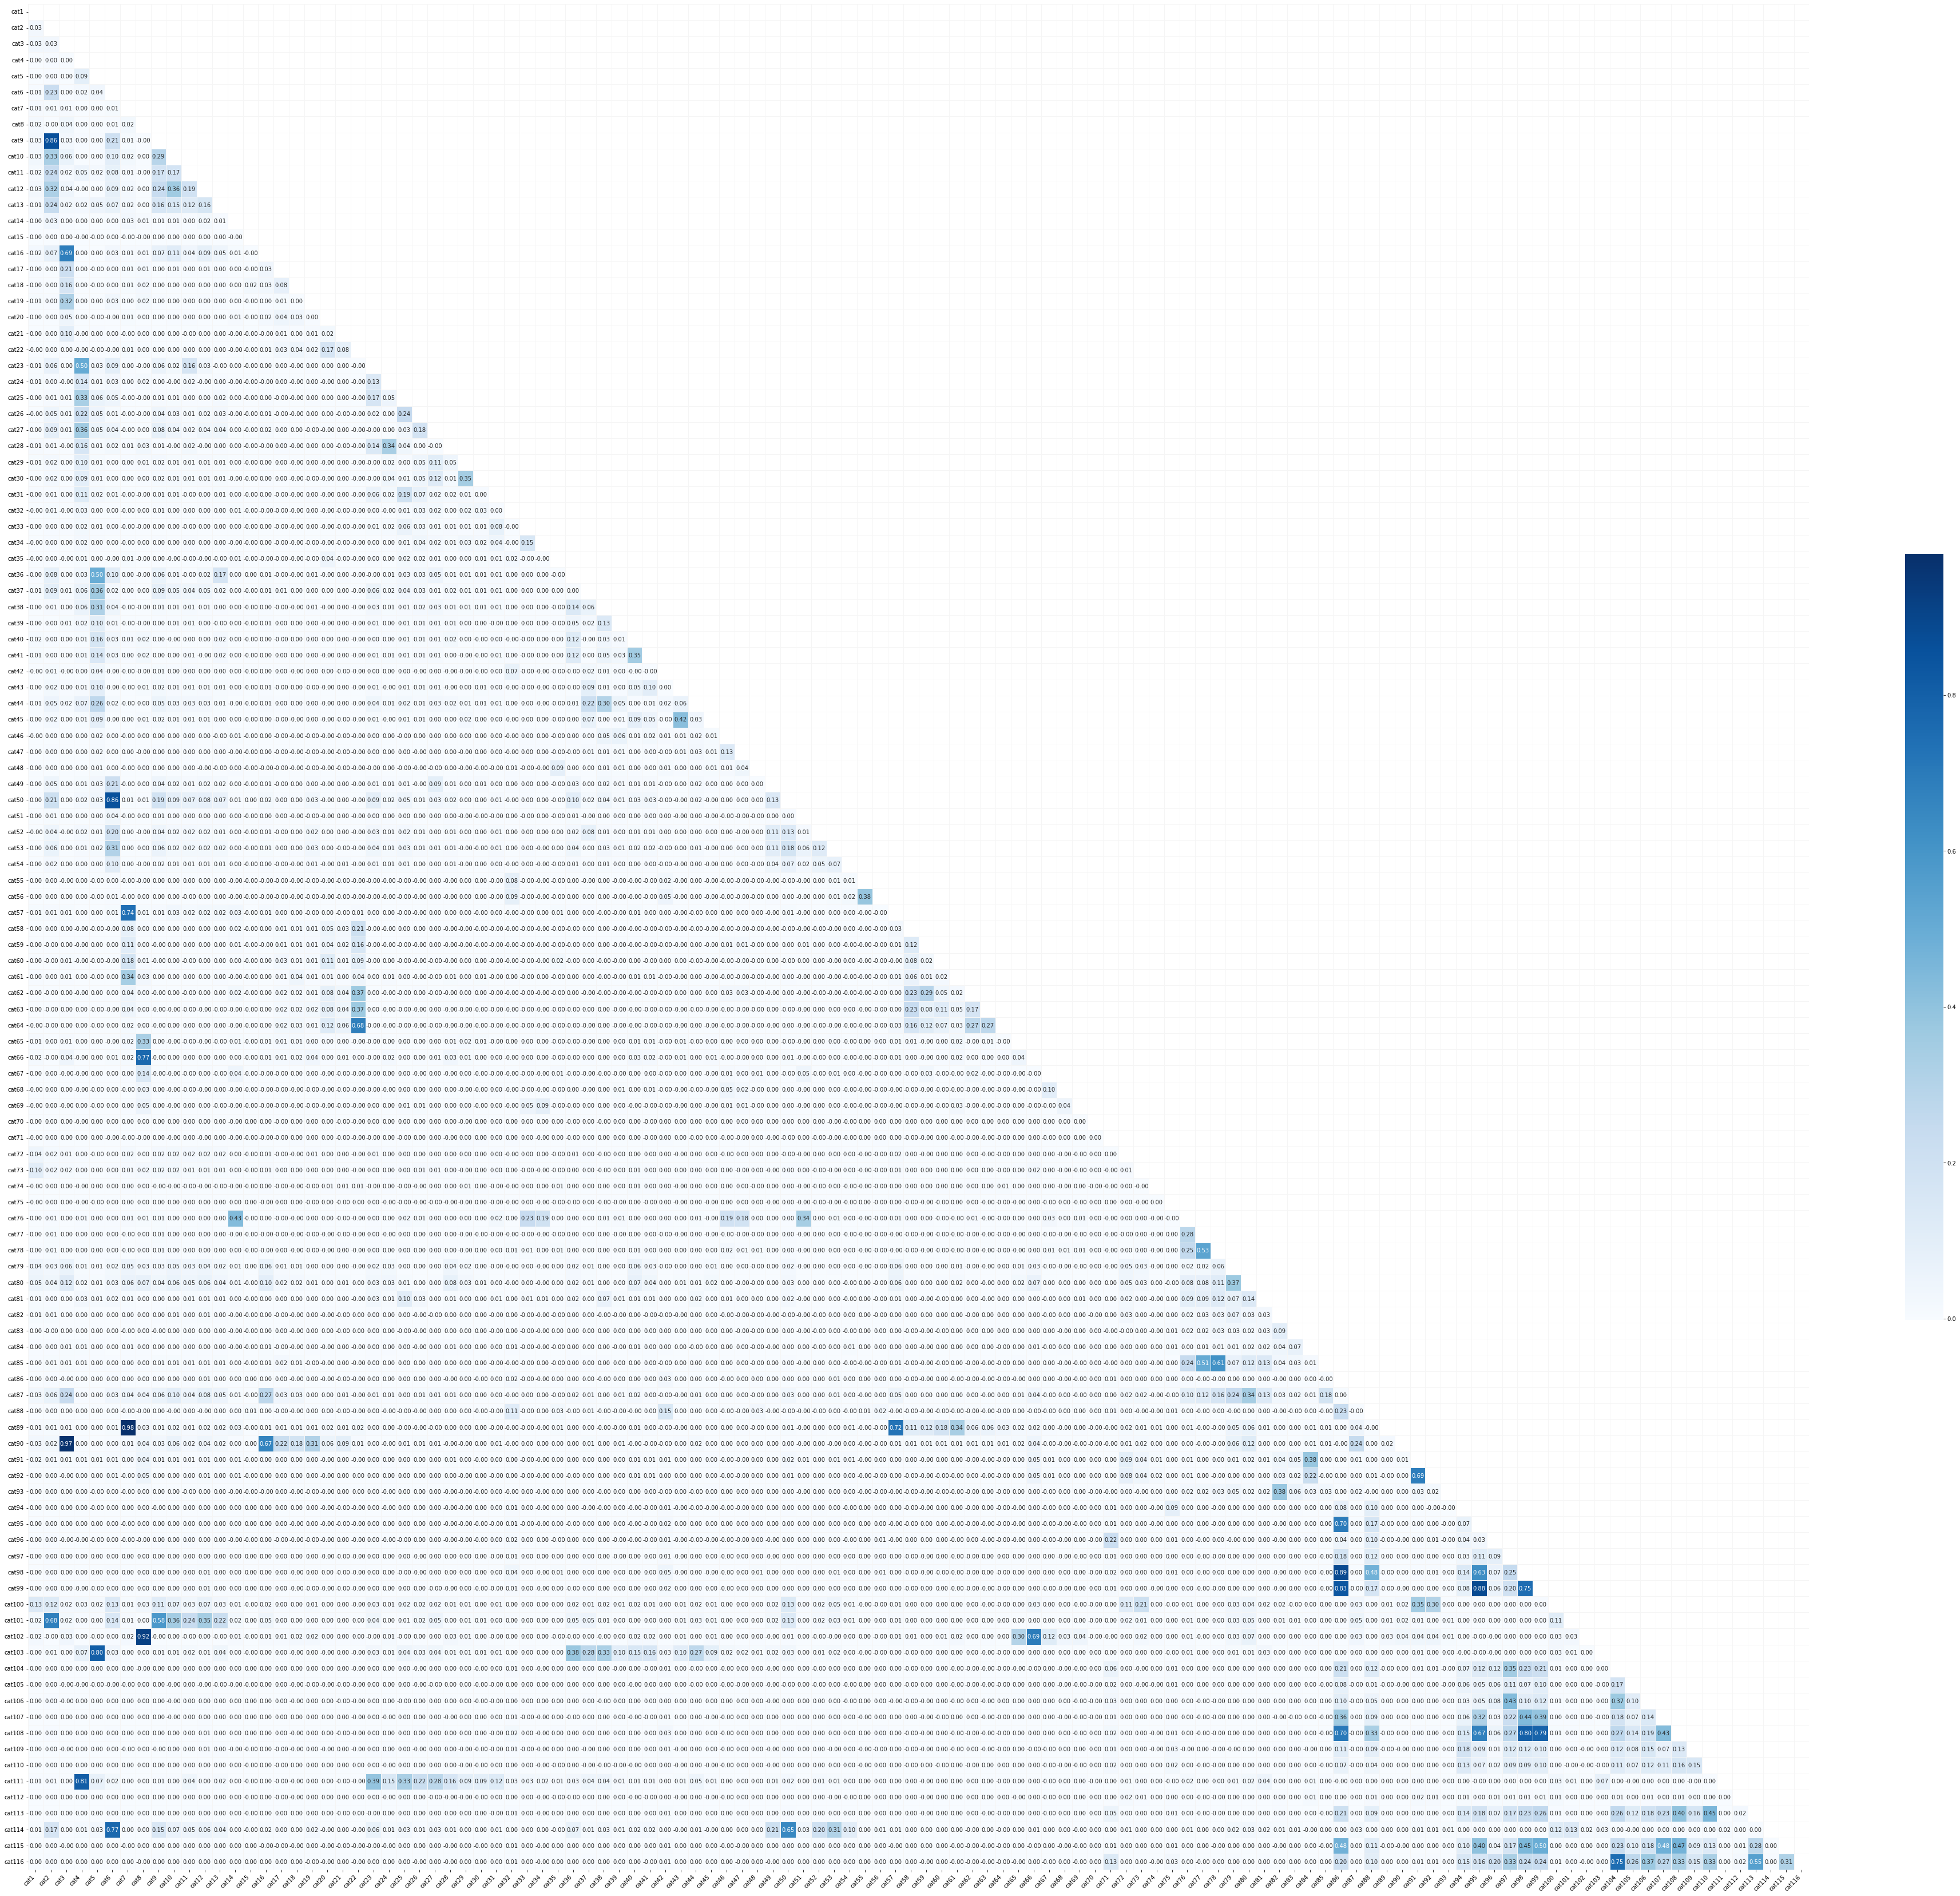

In [16]:
# plot mutual information matrix

# create a mask to keep only half of matrix
trimask_categorical = np.triu(np.ones_like(mutual_info_matrix, dtype=bool))

plt.figure(figsize=(60, 60))
heatmap = sns.heatmap(mutual_info_matrix, linewidth=1, linecolor='whitesmoke', cmap='Blues', mask=trimask_categorical,  annot=True, fmt='.2f', cbar_kws={'fraction': 0.02})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')

None  # don't show the label objects

That is one huge correlation matrix! As you have noticed, the matrix plot is too cumbersome to read due to large number of categorical features. But don't worry, we can extract only the top correlations without being forced to investigate the whole plot.

__IMPORTANT:__<br>
The above plot should not be interpreted the same way we do with correlation matrix, because values have been scaled in each row (for easier color visualizations). Read it with "one particular row at a time" mindset if you want to know how well a categorical column correlates relatively to other categorical features. Don't judge multiple rows against each other.

Let's do some more coding to print out only top relative correlations:

In [17]:
# create a dictionary with categorical feature pairs as keys, and mutual score as value
categorical_corr_dict = dict()
for i, scores_list in enumerate(mutual_scores):
    for j, score in enumerate(scores_list):
        categorical_corr_dict[(features_categorical[i], features_categorical[j])] = mutual_scores[i][j]

In [18]:
# create score pairs dataframe
mi_score_df = pd.DataFrame.from_dict(categorical_corr_dict, orient='index', columns=['mutual_info_score'])
mi_score_df

,mutual_info_score
"(cat1, cat1)",1.0000
"(cat1, cat2)",0.0271
"(cat1, cat3)",0.0295
"(cat1, cat4)",0.0017
"(cat1, cat5)",0.0008
...,...
"(cat116, cat112)",0.0189
"(cat116, cat113)",0.5540
"(cat116, cat114)",0.0035
"(cat116, cat115)",0.3118


In [19]:
# sort dataframe by scores
mi_score_df_sorted = mi_score_df.sort_values(by=['mutual_info_score'], ascending=False)

# there are two values for each pair: (column_name, other_column_name) <--> (other_column_name, column_name)
# slice scores dataframe every two rows
mi_score_df_sorted_final = mi_score_df_sorted[mi_score_df_sorted['mutual_info_score'] < 1][::2]
mi_score_df_sorted_final

,mutual_info_score
"(cat7, cat89)",0.9810
"(cat90, cat3)",0.9714
"(cat102, cat8)",0.9159
"(cat98, cat86)",0.8880
"(cat99, cat95)",0.8828
...,...
"(cat77, cat61)",-0.0014
"(cat77, cat67)",-0.0014
"(cat46, cat77)",-0.0014
"(cat109, cat84)",-0.0015


In [20]:
# let's review the top 30
mi_score_df_sorted_final[:30]

,mutual_info_score
"(cat7, cat89)",0.9810
"(cat90, cat3)",0.9714
"(cat102, cat8)",0.9159
"(cat98, cat86)",0.8880
"(cat99, cat95)",0.8828
"(cat2, cat9)",0.8619
"(cat50, cat6)",0.8551
"(cat99, cat86)",0.8329
"(cat111, cat4)",0.8117
"(cat103, cat5)",0.8006


Ok! that was quite a journey to extract these similarity scores for categorical features. There are two very highly correlated categorical features on top:<br>
- (cat7, cat89): 0.9810
- (cat90, cat3): 0.9714

Looking at value distribution plots we created for categorical features earlier, I decided to drop _'cat3'_ and _'cat7'_ in favor of _'cat90'_ and _'cat89'_. The reason IMHO is that the latter ones represent larger number of sub-classes which could be useful for our model.

We should feel better now. After all, the less redundant features, the better.

## Missing Values
We need to figure out if our dataset contains any missing cell infos. This is a critical checking in order to avoid data errors in training phase. Just take a note that we need to do checking for both train & test datasets.

In [21]:
missing_values_count_train = sum(df_train_full.isnull().sum().tolist())
missing_values_count_test  = sum(df_test.isnull().sum().tolist())

train_columns_with_missing_values, test_columns_with_missing_values = [], []
if missing_values_count_train > 0:
    train_columns_with_missing_values = df_train_full.columns[df_train_full.isnull().any()]
if missing_values_count_test  > 0:
    test_columns_with_missing_values  = df_test.columns[df_test.isnull().any()]


print(f'Train Columns with Missing Values: {missing_values_count_train}\n{train_columns_with_missing_values}', '\n')
print(f'Test Columns with Missing Values: {missing_values_count_test}\n{test_columns_with_missing_values}', '\n')

Train Columns with Missing Values: 0
[] 

Test Columns with Missing Values: 0
[] 



We are in our lucky day! No missing values for the subject dataset. But we need to be aware that most of time this won't happen and we need to handle those missing values before moving to training.

### Strategies to Handle Missing Values
Depending on the problem, missing values should be handled with intuition enforced by domain knowledge over the subject matter.<br>
Being blessed with domain knowledge (either through perception induced by column names, or acquired data descriptions) helps a lot to have an idea about how to handle missing data. Domain knowledge makes it more clear why the value is missing. You may have a decisive answer to whether the missing data is due to the lack of recording or the lack of existence in nature.<br>

There are three general approaches to handle missing values:
- __Drop Column (or Rows) with Missing Values:__ This is the simplest option, but not a good one. We may loose a lot of useful info just by dropping a column. Also, removing rows with missing values could be devastating for datasets with fewer sample counts.
- __Imputation (Filling them with Values):__ This is the standard go-to option when it comes to handling missing values. Depending on the data type (numerical or categorical), we can name several filling strategies: fill with zero (0), mean (average), most common occurrence, etc. Domain knowledge plays a big role in deciding which values should be used for filling in.
- __Extended Imputation:__ Using this approach, not only do we fill the missing values, but we also create another column for each column that has missing values, specifying the sample rows with TRUE or FALSE, which originally lacked a value. In some datasets this will noticeably help improve results.

## Analysis of Target Variable
We know that the column named _'loss'_ holds the regression values we're targeting for this study. Let's see what minimum, maximum, mean and standard deviation values are for this column:

In [22]:
column_target = 'loss'
print(f'Target Column {column_target} Stats:\n')
print(f'min value: {df_train_full[column_target].min()}\n'+
      f'max value: {df_train_full[column_target].max()}\n'+
      f'avg: {df_train_full[column_target].mean()}\n'+
      f'std: {df_train_full[column_target].std()}')

Target Column loss Stats:

min value: 0.67
max value: 121012.25
avg: 3037.3376856699792
std: 2904.0861863904365


Now, it is time to look at the value distribution we have in _'loss'_ column:

<AxesSubplot:xlabel='loss', ylabel='Count'>

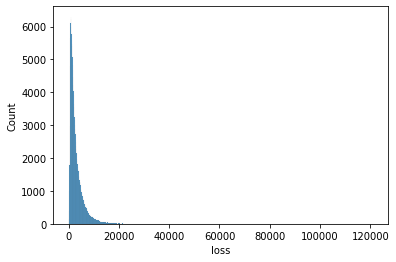

In [23]:
sns.histplot(df_train_full[column_target])

An apparent __highly skewed long-tailed distribution__! This means that we should consider __logarithmic transformation__ of the target column to help our model achieve a better score in training phase.

But, we need to check first to see if a such transformation really improves the distribution. A log-transformed _'loss'_ column looks like this:

<AxesSubplot:ylabel='Count'>

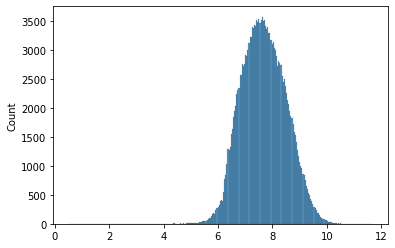

In [24]:
import numpy as np


column_target_transformed = np.log1p(df_train_full[column_target].to_numpy())
sns.histplot(column_target_transformed)

Much better, isn't it? Long live __"Normal Distribution"__!

## Feature Importance Analysis
Remember __"correlation & mutual information analysis"__ we investigated earlier? We can use these notions to explore features importance for our target column, in a __linear__ manner.

We already know that our target column is of continues numerical type (we have a regression problem). Hence, we can easily calculate the correlation it has with numerical features. However, in order to extract it's correlation scores with categorical features, we'll need to change target column into categorical and calculate mutual info scores from that.

### Numerical Feature Importance Analysis

In [25]:
# we would to like to score linear relationship between numerical features and the target variable

feature_importance_data_numerical = df_train_full[features_numerical+[column_target]]

correlation = feature_importance_data_numerical.corr()
correlation[[column_target]].sort_values([column_target], ascending=False)

,loss
loss,1.000000
cont2,0.141528
cont7,0.119799
cont3,0.111053
cont11,0.099806
cont12,0.098724
cont6,0.040967
cont8,0.030508
cont10,0.020236
cont14,0.019298


The above scores indicate that numerical features alone don't exhibit a linear relationship with our target column.

### Categorical Feature Importance Analysis
We know the mutual info score function is not that fast. We had to subsample our data before, in order to run the function on our dataset's large count of categorical features. The same logic holds here.

Since our target column is of continuos numerical type in nature, we'll have to map it into a categorical space. Pandas has a quantile-based discretization function that allows us to transform our continuos target column into equal-sized buckets of categories, taking value distributions into account. Fantastic!

In [26]:
# subsampling the dataset
RANDOM_SEED = 1024
subsample_fraction = 0.06
max_samples = int(subsample_fraction * len(df_train_full))
df_train_subsample = df_train_full.sample(n=max_samples, random_state=RANDOM_SEED)

# using pandas qcut function to create 10 equal-sized buckets of values for target column
target_column_categorical = pd.qcut(df_train_subsample[column_target], q=10)

In [27]:
# calculate scores from subsample dataframe
feature_importance_scores_categorical = list()
for categorical_feature in features_categorical:
    mi_score = adjusted_mutual_info_score(df_train_subsample[categorical_feature], target_column_categorical)
    feature_importance_scores_categorical.append(mi_score)

In [28]:
# create categorical feature importance scores dataframe
df_categorical_feature_importance_scores = pd.DataFrame(feature_importance_scores_categorical, index=features_categorical, columns=[column_target])

# sort values in descending order and display the top 30
df_categorical_feature_importance_scores.sort_values(by=[column_target], ascending=False)[:30]

,loss
cat80,0.086596
cat79,0.064905
cat87,0.041966
cat12,0.041925
cat101,0.039875
cat10,0.033030
cat100,0.032426
cat81,0.029042
cat1,0.025273
cat2,0.021406


The above scores reveal that categorical features alone don't hold much of a linear relationship with our target column, even less so compared to numerical features.